# ART calculations for `Lassa` virus

In [10]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [51]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle
import cloudpickle
import matplotlib.pyplot as plt

%run "./plotting.py"

### Define directories

In [12]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')
artResultDir = resultsDir + 'ART_results/Lassa'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [13]:
LassaVirusData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "LassaVirusData_chEMBL_wMACAW.csv")
LassaVirusData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,VirusClassifier,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL2314868,CCOc1ccc(Cn2cnc3cc(NCc4ccc(CC)cc4)cnc32)cc1,5.795880,Lassa,-0.106164,0.068554,0.032721,0.109189,-0.017199,0.020952,-0.078101,-0.064668,0.023512,-0.136794,0.066696,-0.171314,0.207797,-0.079812,0.075790
1,2,CHEMBL2315151,CCOc1ccc(-n2cnc3cc(NCc4ccc(CC)cc4)cnc32)nc1,9.008774,Lassa,-0.281881,0.167886,-0.078043,0.149711,0.056406,0.222884,0.073333,-0.080336,-0.048408,-0.020429,0.006866,-0.030988,-0.017732,-0.014060,0.123784
2,3,CHEMBL2315139,CCOc1ccc(-n2ccc3cc(NCc4ccc(CC)cc4)ccc32)cc1,7.161151,Lassa,-0.258976,0.185137,-0.025870,0.018784,0.065404,0.219836,-0.022163,-0.047569,0.000458,-0.036640,-0.018893,0.090552,0.013784,0.035334,-0.061203
3,4,CHEMBL2314867,CCOc1ccc(-n2cnc3cc(/N=C/c4ccc(CC)cc4)cnc32)cc1,5.366532,Lassa,-0.236141,0.094972,-0.066297,0.072595,0.062417,0.196901,0.053974,-0.048199,-0.054479,0.006781,-0.016171,0.053919,-0.027513,-0.020923,0.104515
4,5,CHEMBL2322815,COc1ccc(-n2cnc3cc(NCc4ccccc4OC)ccc32)cc1,6.337242,Lassa,-0.154547,0.005202,-0.035988,-0.139993,0.096835,-0.147745,-0.123911,-0.208460,0.103461,0.205669,0.117765,-0.121497,0.070682,-0.047141,-0.084611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,208,CHEMBL4860136,CC(C)Oc1ccc(-c2ccc3ncn(-c4ccc(OC(C)C)cc4)c3c2)cc1,9.086186,Lassa,-0.000113,-0.496480,0.061151,-0.043296,0.004456,0.006432,0.027172,-0.025270,0.054443,-0.033372,0.136562,0.052586,-0.112585,0.070967,0.089517
185,209,CHEMBL4854274,Cc1cc2nnn(-c3ccc(OC(C)C)cc3)c2cc1-c1ccc(OC(C)C...,8.978811,Lassa,0.006697,-0.417292,0.050142,-0.033306,-0.022042,0.015459,0.099515,0.019123,0.071139,0.067132,0.212328,0.077049,-0.140526,0.142824,0.141077
186,213,CHEMBL4864023,CC(C)Oc1ccc(-c2cnc3ccc(-c4ccc(C5(N)CC5)cc4)cn2...,8.098542,Lassa,0.027347,-0.290715,0.064375,0.067077,0.031102,-0.024661,-0.127231,0.088436,-0.009115,-0.060581,-0.220903,-0.041610,0.115324,-0.133914,-0.066594
187,214,CHEMBL4851799,Cc1c(-c2ccc(OC(C)C)cc2)ccc2ncc(-c3ccc(OC(C)C)c...,9.494850,Lassa,0.014423,-0.515713,0.068367,-0.024527,-0.018676,0.014993,0.008540,-0.010087,0.070725,-0.063690,0.056843,0.044289,-0.067376,0.015958,0.046075


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

#### Find Features and Response

In [14]:
input_var = [col for col in LassaVirusData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [15]:
features = LassaVirusData_chEMBL_wMACAW[input_var].to_numpy()

In [16]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [17]:
response = LassaVirusData_chEMBL_wMACAW[response_var].to_numpy()

### save the data as a EDD style file

In [18]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'LassaVirusData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [19]:
LassaVirusData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "LassaVirusData_chEMBL_wMACAW_ARTready.csv")
LassaVirusData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.106164
1,1,MACAW_1,-0.281881
2,2,MACAW_1,-0.258976
3,3,MACAW_1,-0.236141
4,4,MACAW_1,-0.154547
...,...,...,...
3019,184,pPotency,9.086186
3020,185,pPotency,8.978811
3021,186,pPotency,8.098542
3022,187,pPotency,9.494850


### Define the ART parameters needed for the prediction

In [20]:
art_params = {
    'input_vars': input_var,
    'response_vars': response_var,
    'objective': 'maximize',
    'threshold': 0.2,
    'alpha': 0.5,
    'num_recommendations': 10,
    'max_mcmc_cores': 4,
    'seed': 42,                    
    'output_dir': artResultDir,
    'recommend': False,
    'cross_val': True,
    'num_tpot_models': 2,
}

### Run ART without recommendations but with cross-validations to gauge how generalizable the results are

ART identified 189 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_regressor
is_regressor
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_regressor
is_regressor
is_classifier
is_classifier
is_classifier
is

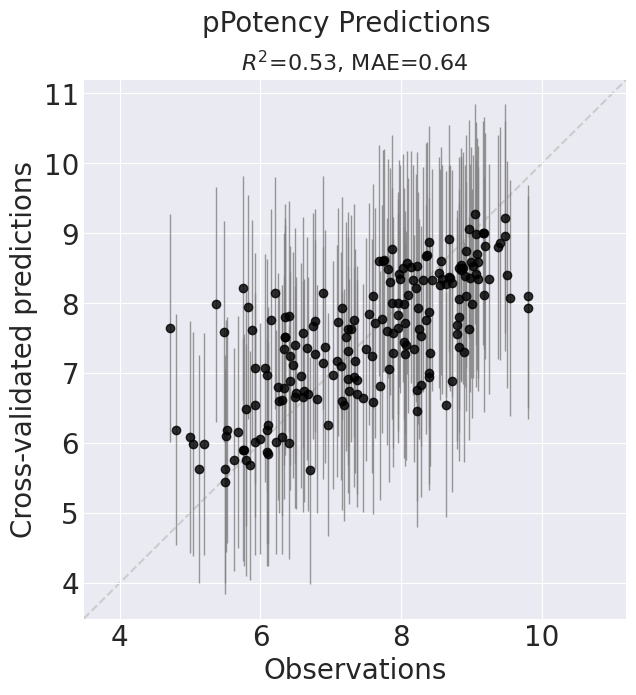

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
i

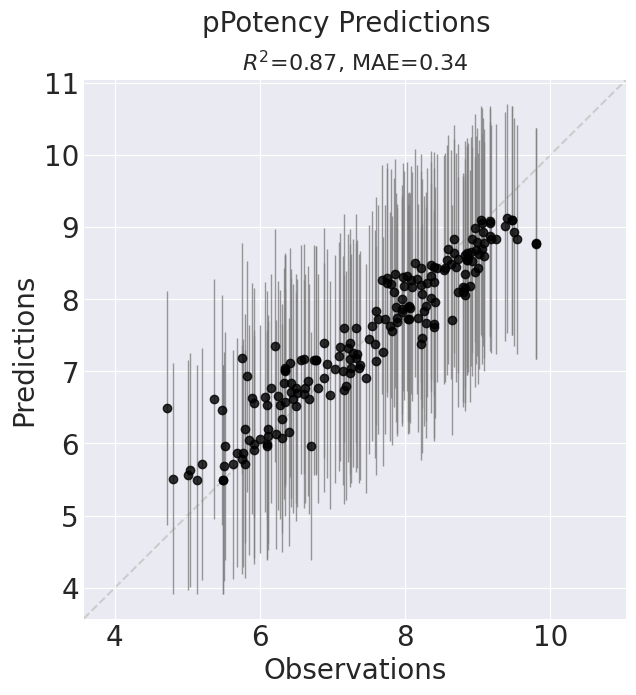

CPU times: user 23min 6s, sys: 7.07 s, total: 23min 13s
Wall time: 1h 18min 14s


In [21]:
%%time

art = RecommendationEngine(df=LassaVirusData_chEMBL_wMACAW_ARTready, **art_params)

In [17]:
import shap
import matplotlib.pyplot as plt

### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [18]:
shap.initjs()

In [ ]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [ ]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [ ]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)

In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


### Load pre-trained ART model (if necessary, otherwise skip this step)

In [5]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    art = cloudpickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

 ART model loaded from: /code/DTRA_ART/DrugDesignData/Results/ART_results/Lassa/art.cpkl


In [67]:
ART_inputDF = pd.DataFrame(art.X, columns=art_params.get('input_vars'))
ART_inputDF.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_ART_inputData.csv.csv"), index=False)
ART_inputDF

,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,-0.106164,0.068554,0.032721,0.109189,-0.017199,0.020952,-0.078101,-0.064668,0.023512,-0.136794,0.066696,-0.171314,0.207797,-0.079812,0.075790
1,-0.281881,0.167886,-0.078043,0.149711,0.056406,0.222884,0.073333,-0.080336,-0.048408,-0.020429,0.006866,-0.030988,-0.017732,-0.014060,0.123784
2,-0.258976,0.185137,-0.025870,0.018784,0.065404,0.219836,-0.022163,-0.047569,0.000458,-0.036640,-0.018893,0.090552,0.013784,0.035334,-0.061203
3,-0.236141,0.094972,-0.066297,0.072595,0.062417,0.196901,0.053974,-0.048199,-0.054479,0.006781,-0.016171,0.053919,-0.027513,-0.020923,0.104515
4,-0.154547,0.005202,-0.035988,-0.139993,0.096835,-0.147745,-0.123911,-0.208460,0.103461,0.205669,0.117765,-0.121497,0.070682,-0.047141,-0.084611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,-0.000113,-0.496480,0.061151,-0.043296,0.004456,0.006432,0.027172,-0.025270,0.054443,-0.033372,0.136562,0.052586,-0.112585,0.070967,0.089517
185,0.006697,-0.417292,0.050142,-0.033306,-0.022042,0.015459,0.099515,0.019123,0.071139,0.067132,0.212328,0.077049,-0.140526,0.142824,0.141077
186,0.027347,-0.290715,0.064375,0.067077,0.031102,-0.024661,-0.127231,0.088436,-0.009115,-0.060581,-0.220903,-0.041610,0.115324,-0.133914,-0.066594
187,0.014423,-0.515713,0.068367,-0.024527,-0.018676,0.014993,0.008540,-0.010087,0.070725,-0.063690,0.056843,0.044289,-0.067376,0.015958,0.046075


In [68]:
ART_responseDF = pd.DataFrame(art.y, columns=art_params.get('output_vars')
    if art.y.ndim > 1 else ['response'])
ART_responseDF.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_ART_responseData.csv"), index=False)
ART_responseDF

,0
0,5.795880
1,9.008774
2,7.161151
3,5.366532
4,6.337242
...,...
184,9.086186
185,8.978811
186,8.098542
187,9.494850


In [69]:
ART_predictionDF = art.model_prediction_dfs[0]
ART_predictionDF

,Predictions,MAE,MRAE(%),StdAE,MSE,$R^2$,omega_mean,omega_std
Name,,,,,,,,
Neural Regressor,"[6.327828645595428, 7.819811372678568, 7.69351...",0.418491,5.866948,0.418886,0.350600,0.767697,0.025022,0.030491
Random Forest Regressor,"[6.148975851077268, 8.564234490920908, 7.43831...",0.245768,3.468377,0.201764,0.101111,0.933005,0.058742,0.075749
Support Vector Regressor,"[6.431525114739896, 7.812528496356734, 7.77978...",0.452768,6.455362,0.477222,0.432740,0.713273,0.081743,0.09251
Kernel Ridge Regressor,"[5.154905764650275, 7.496466394252457, 7.67165...",0.693862,9.447463,0.502677,0.734128,0.513576,0.025721,0.026479
K-NN Regressor,"[6.671769929754419, 8.451535933163658, 7.60746...",0.588187,8.453860,0.505546,0.601541,0.601427,0.031672,0.040756
Gaussian Process Regressor,"[6.44898947295855, 7.711218912873569, 7.707590...",0.491722,6.905477,0.432010,0.428423,0.716133,0.069655,0.083889
Gradient Boosting Regressor,"[6.139682580438665, 8.59417040649016, 7.582266...",0.245863,3.398446,0.181245,0.093298,0.938182,0.058815,0.07063
TPOT Regressor 1,"[6.365414510109706, 8.40319168091035, 7.673520...",0.424393,5.976157,0.342155,0.297180,0.803093,0.313129,0.180177
TPOT Regressor 2,"[5.9891295, 8.812614, 7.4800344, 5.7460394, 6....",0.239937,3.338320,0.209667,0.101530,0.932728,0.335502,0.176455


In [70]:
ART_predictionDF_ensembleModel = ART_predictionDF.loc['Ensemble Model (L1)', 'Predictions']
# Convert to DataFrame
ART_predictionDF_ensembleModelDF = pd.DataFrame({
    'Predicted_Value': ART_predictionDF_ensembleModel
})
ART_predictionDF_ensembleModelDF.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_ART_ensembleModel_predictionData.csv"), index=False)
ART_predictionDF_ensembleModelDF

,Predicted_Value
0,6.202033
1,8.428377
2,7.598842
3,6.614954
4,6.574441
...,...
184,8.774005
185,8.684512
186,8.175292
187,8.932501


Saved: /code/DTRA_ART/DrugDesignData/Results/Lassa/LassaVirus_ART_ensembleModel_parityPlot.svg
Saved: /code/DTRA_ART/DrugDesignData/Results/Lassa/LassaVirus_ART_ensembleModel_parityPlot.png


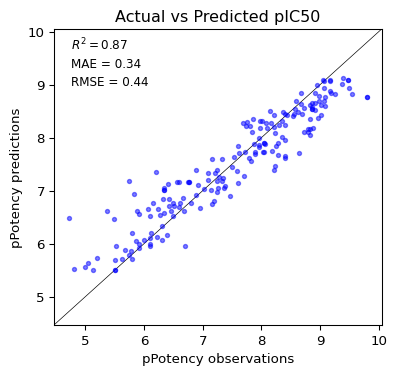

In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Apply the same matplotlib settings
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['figure.dpi'] = 96
matplotlib.rcParams['savefig.dpi'] = 300

# Get Ensemble Model predictions
ensemble_predictions = ART_predictionDF_ensembleModelDF.values.flatten()

# Get actual values
actual_values = ART_responseDF.values.flatten()

# Get metrics for the title
r2 = ART_predictionDF.loc['Ensemble Model (L1)', '$R^2$']
mae = ART_predictionDF.loc['Ensemble Model (L1)', 'MAE']
mse = ART_predictionDF.loc['Ensemble Model (L1)', 'MSE']
rmse = np.sqrt(mse)

# Plot actual vs predicted
plt.figure(figsize=(4.4, 4.0))

# Find the boundaries of X and Y values
min1 = min(actual_values.min(), ensemble_predictions.min())
max1 = max(actual_values.max(), ensemble_predictions.max())
rng1 = max1 - min1
bounds = (min1 - 0.05 * rng1, max1 + 0.05 * rng1)

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)

# Plot the diagonal
ax.plot([0, 1], [0, 1], 'k-', lw=0.5, transform=ax.transAxes)

# Plot the data
plt.errorbar(x=actual_values, y=ensemble_predictions, yerr=None, 
             color='blue', fmt='.', elinewidth=.5, alpha=0.5)

# Add metrics text
r2_text = f"$R^2 = {r2:0.2f}$"
mae_text = f"MAE = {mae:0.2f}"
rmse_text = f"RMSE = {rmse:0.2f}"
ax.text(0.05, 0.93, r2_text, transform=ax.transAxes, fontsize=9.)
ax.text(0.05, 0.87, mae_text, transform=ax.transAxes, fontsize=9.)
ax.text(0.05, 0.81, rmse_text, transform=ax.transAxes, fontsize=9.)

# Title and labels
plt.title('Actual vs Predicted pIC50')
plt.xlabel('pPotency observations')
plt.ylabel('pPotency predictions')

# Save in multiple formats
savetitle = os.path.join(resultsDir, "Lassa/LassaVirus_ART_ensembleModel_parityPlot")
save_formats = ['svg', 'png']

for fmt in save_formats:
    output_path = f"{savetitle}.{fmt}"
    plt.savefig(output_path, format=fmt, dpi=300, bbox_inches='tight', transparent=False)
    print(f"Saved: {output_path}")

plt.show()
plt.close()

In [55]:
# Convert list of model results into a long DataFrame
predictionList = art.model_prediction_dfs  # list of dicts
recordList = []
for rec in predictionList:
    modelName = rec.get('Name', rec.get('name'))
    preds = rec.get('Predictions')
    if preds is None:
        continue
    for i, p in enumerate(preds):
        recordList.append({
            'modelName': modelName,
            'sampleIndex': i,
            'prediction': p,
        })

dfLong = pd.DataFrame.from_records(recordList)
dfLong

,modelName,sampleIndex,prediction
0,None,0,"[6.327828645595428, 7.819811372678568, 7.69351..."
1,None,1,"[6.148975851077268, 8.564234490920908, 7.43831..."
2,None,2,"[6.431525114739896, 7.812528496356734, 7.77978..."
3,None,3,"[5.154905764650275, 7.496466394252457, 7.67165..."
4,None,4,"[6.671769929754419, 8.451535933163658, 7.60746..."
5,None,5,"[6.44898947295855, 7.711218912873569, 7.707590..."
6,None,6,"[6.139682580438665, 8.59417040649016, 7.582266..."
7,None,7,"[6.365414510109706, 8.40319168091035, 7.673520..."
8,None,8,"[5.9891295, 8.812614, 7.4800344, 5.7460394, 6...."
9,None,9,"[6.202032533115635, 8.428377077184582, 7.59884..."


In [50]:
# True values
yTrue = np.ravel(art.y)
dfTrue = pd.DataFrame({'sampleIndex': np.arange(len(yTrue)), 'true': yTrue})

# Merge predictions with true values
dfCombined = dfLong.merge(dfTrue, on='sampleIndex', how='left')

# Plot true vs predicted for each model
for modelName, group in dfCombined.groupby('modelName'):
    plt.figure(figsize=(6, 6))
    plt.scatter(group['true'], group['prediction'], alpha=0.5, s=5)
    minVal = min(group['true'].min(), group['prediction'].min())
    maxVal = max(group['true'].max(), group['prediction'].max())
    plt.plot([minVal, maxVal], [minVal, maxVal], 'k--', lw=1)  # diagonal
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{modelName} — True vs Predicted')
    plt.tight_layout()
    plt.show()


### Load MACAW transformer (not required at this moment)

## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

Load MACAW embeedings for external validation data set

In [22]:
LassaVirus_EnamineDatasets_wMACAW = pd.read_csv(resultsDir + "Lassa/LassaVirus_EnamineDataset_wMACAW.csv")
LassaVirus_EnamineDatasets_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,0.106481,-0.013249,0.038486,0.120186,-0.035323,-0.115029,-0.012685,-0.002625,-0.021709,0.035241,0.024042,-0.037883,0.069756,0.027992,0.001265
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,0.141674,0.043886,0.052703,0.087347,0.006226,-0.099388,-0.045490,0.036975,-0.031701,0.010327,0.009601,-0.036287,0.050462,0.067869,0.002291
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,0.107149,0.029101,0.108835,0.149187,-0.002866,-0.112939,-0.007188,0.058189,0.012291,0.021376,0.010707,-0.030796,0.072709,0.037326,0.042105
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,0.134890,0.026482,0.111325,0.125759,-0.024722,-0.098501,0.005705,0.027235,0.006090,0.006749,0.029416,-0.057419,0.013372,0.039360,0.030378
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,0.129567,0.041920,0.085646,0.117064,0.003087,-0.089951,-0.040825,0.080610,0.017279,0.022769,0.008847,-0.028570,0.062447,0.012392,-0.004628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,0.151332,0.054992,0.103202,0.168320,-0.009616,-0.092888,0.008756,0.001749,0.032075,0.003538,0.013687,-0.022183,0.039068,0.016276,-0.004420
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,0.192810,-0.036904,-0.006297,0.070651,0.025736,-0.084829,-0.023961,0.045435,-0.043807,0.008218,0.046772,0.007265,0.073020,0.048551,0.016963
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,0.116830,0.011995,0.128323,0.139771,-0.040290,-0.109954,0.019354,0.035271,-0.031710,0.032013,0.012751,-0.025098,0.023449,0.048491,0.057613
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,0.123584,0.045999,0.128589,0.129980,0.005331,-0.081347,-0.005583,0.024219,0.014013,0.004328,-0.008779,0.003706,0.073704,0.093210,0.038286


In [23]:
macaw_columns = [col for col in LassaVirus_EnamineDatasets_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_EnamineDatasets_wMACAW = LassaVirus_EnamineDatasets_wMACAW[macaw_columns].values

In [24]:
Y1_lib_pred = art.predict(smi_lib_EnamineDatasets_wMACAW)
Y1_lib_pred

array([[6.50240213],
       [6.8737142 ],
       [6.30829409],
       ...,
       [6.2254272 ],
       [6.33005692],
       [6.53328035]])

Get predictions with uncertainty using ART's post_pred_stats

In [25]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_EnamineDatasets_wMACAW)

# Now use these for your results
EnamineAntiviralsData_predicted = LassaVirus_EnamineDatasets_wMACAW[['SMILES']].copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_EnamineDataset_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_EnamineDataset_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,6.502402,0.818093,4.898940,8.105864,3.144835e-07,7.836754e-09,0.000013
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,6.873714,0.830752,5.245440,8.501988,1.337475e-07,3.147833e-09,0.000006
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,6.308294,0.819600,4.701877,7.914711,4.917065e-07,1.216996e-08,0.000020
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,6.384102,0.827619,4.761969,8.006234,4.129505e-07,9.857472e-09,0.000017
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,6.717686,0.826780,5.097196,8.338175,1.915641e-07,4.590127e-09,0.000008
...,...,...,...,...,...,...,...,...
3195,CCOC=1N=CC=CC1NC(=O)NC2CCN3CCCCC23,6.222731,0.818726,4.618028,7.827433,5.987826e-07,1.487875e-08,0.000024
3196,CC1=NN(CC(O)C=2C=CC=CC2)C(=O)C(C#N)=C1C,6.970429,0.834436,5.334933,8.605924,1.070462e-07,2.477857e-09,0.000005
3197,CCC1=NN=NN1CC(=O)NC2CCN(CC2)C(C)=O,6.225427,0.820464,4.617317,7.833537,5.950765e-07,1.467111e-08,0.000024
3198,CC=1C=C2N=CN(CC(O)CN3CCS(=O)CC3)C2=CC1C,6.330057,0.822538,4.717883,7.942230,4.676738e-07,1.142272e-08,0.000019


## 2.2 Discovery of new hits specific to all viruses (data source Life chemicals data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [26]:
LassaVirus_LCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Lassa/LassaVirus_LCAntiviralsData_wMACAW.csv")
LassaVirus_LCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,0.140204,0.055297,0.134857,0.117615,0.008551,-0.104156,-0.040997,0.015430,0.007769,-0.024462,0.011213,-0.014047,0.047717,0.057500,0.018579
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,0.135588,0.027449,0.130481,0.133388,-0.006279,-0.152871,-0.039894,0.080951,-0.073830,0.028840,0.012729,-0.029278,0.055905,0.053506,0.058636
2,CN1CCCN(Cc2ccncc2)CC1,0.124903,0.014160,0.146232,0.119058,0.029748,-0.154967,-0.006562,0.051542,-0.018122,-0.003870,-0.012357,-0.021075,0.021043,0.070979,0.053429
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,0.144697,0.009699,0.114511,0.116287,0.007203,-0.123139,-0.014641,0.041717,-0.024385,0.015123,0.024306,0.009161,0.050450,0.087400,0.071105
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,0.145767,-0.010630,0.134656,0.132732,0.009655,-0.157440,-0.013505,0.032409,-0.034977,-0.014470,0.026398,-0.006346,0.020713,0.084512,0.033144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,0.045357,-0.013191,0.110791,0.013394,0.045156,-0.070641,-0.037380,0.024411,0.006979,-0.003679,-0.037777,0.014781,0.126370,0.084625,-0.003695
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,0.055969,0.030672,0.150282,0.033732,-0.000637,-0.103191,-0.044760,0.062577,0.004073,-0.006309,0.009581,0.040313,0.080304,0.027029,-0.003541
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,0.093789,-0.066886,0.045748,0.038996,-0.003744,-0.055688,-0.062257,-0.015641,-0.020399,0.086583,0.001372,0.033160,0.051453,0.057745,-0.056074
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,0.061886,0.035732,0.183954,0.018437,-0.140765,-0.013195,-0.015694,0.101116,0.005790,0.013247,0.006953,0.008942,0.027601,0.038859,-0.021628


In [27]:
macaw_columns = [col for col in LassaVirus_LCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_LCAntiviralsData_wMACAW = LassaVirus_LCAntiviralsData_wMACAW[macaw_columns].values

In [28]:
Y1_lib_pred = art.predict(smi_lib_LCAntiviralsData_wMACAW)
Y1_lib_pred

array([[6.34897218],
       [6.1814426 ],
       [6.21496833],
       ...,
       [7.22969258],
       [6.53345623],
       [6.3820421 ]])

Get predictions with uncertainty using ART's post_pred_stats

In [29]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_LCAntiviralsData_wMACAW)

# Now use these for your results
LCAntiviralsData_predicted = LassaVirus_LCAntiviralsData_wMACAW[['SMILES']].copy()
LCAntiviralsData_predicted['pPotency_prediction'] = mean
LCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
LCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
LCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
LCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
LCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_upper_95CI'])
LCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-LCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
LCAntiviralsData_predicted = LCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

LCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_LCAntiviralsData_predicted_all.csv"), index=False)
LCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_LCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
LCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Cl.O=c1cccc2n1CC1CC2CN(C2CCOCC2)C1,6.348972,0.823260,4.735383,7.962562,4.477420e-07,1.090030e-08,0.000018
1,O=C(O)C1CN(c2nccc(C(F)(F)F)n2)CC12CCC2,6.181443,0.820114,4.574019,7.788866,6.585025e-07,1.626051e-08,0.000027
2,CN1CCCN(Cc2ccncc2)CC1,6.214968,0.823533,4.600843,7.829094,6.095813e-07,1.482198e-08,0.000025
3,Cc1cc(C)nc(N2CC(C(=O)O)C3(CCC3)C2)n1,6.281370,0.821161,4.671894,7.890847,5.231544e-07,1.285741e-08,0.000021
4,c1cc(N(C2CCNCC2)C2CC2)ncn1,6.475862,0.822255,4.864243,8.087481,3.343010e-07,8.175580e-09,0.000014
...,...,...,...,...,...,...,...,...
45568,CCN1C=C/C(=C\C=C\c2cc[n+](CC)c3ccccc23)c2ccccc...,6.683697,0.819792,5.076905,8.290490,2.071585e-07,5.122831e-09,0.000008
45569,CCCN1/C(=C/C=C/c2sc3ccccc3[n+]2CCC)Sc2ccccc21....,6.486845,0.832561,4.855026,8.118665,3.259528e-07,7.609133e-09,0.000014
45570,COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12.Cl,7.229693,0.821860,5.618848,8.840537,5.892606e-08,1.443652e-09,0.000002
45571,CCN1/C(=C/C=C2\CCC(/C=C/c3sc4ccc(Cl)cc4[n+]3CC...,6.533456,0.838352,4.890287,8.176625,2.927816e-07,6.658472e-09,0.000013


## 2.3 Discovery of new hits specific to all viruses (data source `chemDiv` data set)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [30]:
LassaVirus_ChemDivAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Lassa/LassaVirus_ChemDivAntiviralsData_wMACAW.csv")
LassaVirus_ChemDivAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,0.118807,0.035267,0.114702,0.035339,-0.053717,-0.031114,0.035349,0.056688,0.034625,0.055871,-0.008985,0.005630,0.019148,-0.032230,0.005443
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,0.125182,0.035552,0.181964,0.126277,-0.020950,-0.069498,0.020814,0.066801,-0.054606,0.020336,0.009007,-0.030686,0.044062,0.006118,0.005582
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,0.147858,0.025088,0.123731,0.024312,-0.042785,-0.026480,0.067547,0.003950,0.084064,0.112111,0.017210,0.023498,0.053297,-0.001535,0.001053
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,0.093351,0.026923,0.044407,0.158594,-0.118002,0.001913,-0.053654,-0.038541,0.046578,0.038537,-0.004824,0.003226,0.047853,-0.021910,0.037200
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,0.155415,0.065059,0.166955,0.144271,-0.043277,-0.094362,-0.079693,0.030930,0.003064,-0.011983,-0.015507,0.031755,0.017110,0.018249,0.062421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64952,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,0.033581,0.013694,0.111572,0.162001,-0.113408,-0.029737,0.007820,0.087846,0.000482,0.064532,-0.008472,-0.033464,0.040227,-0.029748,0.013181
64953,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,0.026126,0.030664,0.094124,0.155170,-0.115144,-0.027670,-0.031912,0.082367,-0.013928,0.063823,-0.013321,-0.029956,0.038494,-0.044909,0.013021
64954,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,0.056121,0.012932,0.107678,0.170900,-0.104926,-0.071392,-0.008837,0.082684,0.000569,0.064040,-0.019741,-0.029808,0.035923,-0.033036,0.022876
64955,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,0.037498,-0.045462,0.053832,0.090104,-0.111430,-0.030720,0.024102,0.079475,-0.024152,0.128256,-0.012715,-0.054844,0.050752,-0.068789,-0.040628


In [31]:
macaw_columns = [col for col in LassaVirus_ChemDivAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_ChemDivAntiviralsData_wMACAW = LassaVirus_ChemDivAntiviralsData_wMACAW[macaw_columns].values

In [32]:
Y1_lib_pred = art.predict(smi_lib_ChemDivAntiviralsData_wMACAW)
Y1_lib_pred

array([[6.19370343],
       [6.22988523],
       [6.05836143],
       ...,
       [6.18529807],
       [6.56029612],
       [6.59716021]])

Get predictions with uncertainty using ART's post_pred_stats

In [33]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_ChemDivAntiviralsData_wMACAW)

# Now use these for your results
ChemDivAntiviralsData_predicted = LassaVirus_ChemDivAntiviralsData_wMACAW[['SMILES']].copy()
ChemDivAntiviralsData_predicted['pPotency_prediction'] = mean
ChemDivAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
ChemDivAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
ChemDivAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
ChemDivAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
ChemDivAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_upper_95CI'])
ChemDivAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-ChemDivAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
ChemDivAntiviralsData_predicted = ChemDivAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

ChemDivAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_ChemDivAntiviralsData_predicted_all.csv"), index=False)
ChemDivAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_ChemDivAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
ChemDivAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCOc1cccc2sc(N(CCN(C)C)C(=O)COc3ccc(Cl)cc3)nc12,6.193703,0.827728,4.571357,7.816050,6.401718e-07,1.527391e-08,0.000027
1,CCN(CC)CCN(C(=O)CN1C(=O)CCC1=O)c1nc2c(Cl)cccc2s1,6.229885,0.821919,4.618923,7.840847,5.889993e-07,1.442622e-08,0.000024
2,COc1ccc(C)c2sc(N(CCN(C)C)C(=O)C3COc4ccccc4O3)nc12,6.058361,0.816918,4.457202,7.659521,8.742559e-07,2.190175e-08,0.000035
3,CCCc1nnc(C(=O)Nc2ccc(C(=O)NCc3ccco3)cc2)s1,6.544458,0.819596,4.938050,8.150865,2.854581e-07,7.065367e-09,0.000012
4,O=C(NCc1cccc(Cl)c1)c1c2c(nc3ccccc13)C(=O)N(C1C...,6.202925,0.824701,4.586511,7.819339,6.267223e-07,1.515867e-08,0.000026
...,...,...,...,...,...,...,...,...
64952,CCOC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(OC...,6.176599,0.817900,4.573515,7.779683,6.658873e-07,1.660798e-08,0.000027
64953,CCOC(=O)c1c(NC(=O)c2cc3nc(-c4ccc(Br)cc4)cc(C(F...,6.541798,0.822178,4.930329,8.153268,2.872114e-07,7.026386e-09,0.000012
64954,COC(=O)c1c(NC(=O)c2nn3c(C(F)(F)F)cc(-c4cccs4)n...,6.185298,0.819242,4.579584,7.791012,6.526824e-07,1.618035e-08,0.000026
64955,COc1cc(NC(=O)c2nn3c(C(F)(F)F)cc(-c4ccc(Br)cc4)...,6.560296,0.821941,4.949291,8.171301,2.752351e-07,6.740601e-09,0.000011


### 2.4 Discovery of new hits specific to all viruses (data source `SMACC` Antivirals data set)
In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models regr above, which use 15-D MACAW embeddings as their input. In particular, we are interested in molecules with high predicted pPotency.

In [34]:
LassaVirus_SMACCAntiviralsData_wMACAW = pd.read_csv(resultsDir + "Lassa/LassaVirus_SMACCAntiviralsData_wMACAW.csv")
LassaVirus_SMACCAntiviralsData_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,0.165991,0.002152,-0.003833,0.093386,-0.044588,-0.081318,-0.087057,-0.003077,-0.064788,0.020623,0.035170,-0.009355,0.035524,0.007488,0.017947
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,0.093738,-0.000814,0.070510,-0.007432,-0.068313,-0.030677,-0.090603,-0.034450,-0.031202,0.061958,0.047536,0.049077,-0.001265,0.006182,-0.078665
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,0.138533,-0.011154,0.048723,0.076757,-0.041017,-0.083888,-0.012085,-0.001461,-0.082893,0.047115,0.042114,0.013042,0.004980,-0.024036,0.036098
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,0.144478,-0.006102,0.049378,0.084956,0.006617,-0.084755,-0.040258,0.019363,-0.076183,0.015197,0.030132,0.025297,0.018219,0.035850,-0.016926
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,0.166734,0.029430,0.089336,0.013820,-0.044573,-0.030235,-0.063969,0.013902,-0.096677,0.058405,0.010936,0.059572,0.026720,-0.023527,-0.010999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,0.102966,-0.038155,0.006759,0.108888,0.037937,-0.106683,-0.031535,-0.031251,-0.074793,0.011268,0.039653,-0.027752,-0.005711,0.006993,0.003701
1608,S=C1Nc2ccccc2S1,0.116045,-0.024251,0.047118,0.068634,0.023613,-0.110258,-0.034897,-0.000946,-0.082635,-0.000053,0.048187,-0.009308,0.005963,0.043091,-0.009695
1609,SC(=S)N1CCCC1,0.128828,-0.014511,0.103222,0.087212,-0.016940,-0.107274,-0.026014,0.049899,-0.037589,0.014830,0.021845,-0.018231,0.004819,0.044805,0.004300
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,0.084162,-0.069525,0.051098,0.071519,0.011477,-0.105306,-0.060854,-0.028232,-0.096650,0.001015,0.048978,-0.023646,-0.016306,0.052415,-0.009426


In [35]:
macaw_columns = [col for col in LassaVirus_SMACCAntiviralsData_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_SMACCAntiviralsData_wMACAW = LassaVirus_SMACCAntiviralsData_wMACAW[macaw_columns].values

In [36]:
Y1_lib_pred = art.predict(smi_lib_SMACCAntiviralsData_wMACAW)
Y1_lib_pred

array([[6.47528306],
       [6.27770061],
       [6.29141265],
       ...,
       [6.49930895],
       [7.18847656],
       [7.34043072]])

Get predictions with uncertainty using ART's post_pred_stats

In [37]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_SMACCAntiviralsData_wMACAW)

# Now use these for your results
SMACCAntiviralsData_predicted = LassaVirus_SMACCAntiviralsData_wMACAW[['SMILES']].copy()
SMACCAntiviralsData_predicted['pPotency_prediction'] = mean
SMACCAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
SMACCAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
SMACCAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
SMACCAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
SMACCAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_upper_95CI'])
SMACCAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-SMACCAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
SMACCAntiviralsData_predicted = SMACCAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

SMACCAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_SMACCAntiviralsData_predicted_all.csv"), index=False)
SMACCAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_SMACCAntiviralsData_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
SMACCAntiviralsData_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,Brc1ccc(NC(=O)CC2Sc3ncnn3C2=O)cc1,6.475283,0.819699,4.868673,8.081893,3.347472e-07,8.281462e-09,0.000014
1,Brc1ccc(Oc2ccc3NS(=O)(=O)C=C(OC(=O)c4ccccc4)c3...,6.277701,0.825393,4.659930,7.895472,5.275934e-07,1.272121e-08,0.000022
2,Brc1ccc(cc1)C1C2=C(NC(=S)NC2=O)OC2=C1C(=O)NC(=...,6.291413,0.823418,4.677514,7.905311,5.111959e-07,1.243623e-08,0.000021
3,Brc1ccc2C(=O)C(=O)C=Cc2c1,6.906948,0.854785,5.231570,8.582326,1.238945e-07,2.616219e-09,0.000006
4,Brc1ccc2NC(=O)C(=C3SC(=S)N(NS(=O)(=O)c4ccccc4)...,6.297169,0.825927,4.678353,7.915985,5.044651e-07,1.213431e-08,0.000021
...,...,...,...,...,...,...,...,...
1607,S=C1NN=C(Nc2ccccc2)S1,6.524529,0.820996,4.915377,8.133681,2.988623e-07,7.350539e-09,0.000012
1608,S=C1Nc2ccccc2S1,6.663565,0.820091,5.056187,8.270942,2.169879e-07,5.358679e-09,0.000009
1609,SC(=S)N1CCCC1,6.499309,0.826452,4.879463,8.119155,3.167313e-07,7.600547e-09,0.000013
1610,c1coc(c1)-c1nc2ccccc2nc1-c1ccco1,7.188477,0.820379,5.580535,8.796419,6.479231e-08,1.598017e-09,0.000003


### 2.5 Checking drug likeliness of `Remdesivir` and `Molnupiravir`

In [38]:
LassaVirus_DTRA_target_antivirals_wMACAW = pd.read_csv(resultsDir + "Lassa/LassaVirus_DTRA_smiles_wMACAW.csv")
LassaVirus_DTRA_target_antivirals_wMACAW

,SMILES,MACAW_1,MACAW_2,MACAW_3,MACAW_4,MACAW_5,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,0.089785,0.002377,0.108742,0.083501,-0.144436,-0.031407,-0.026182,0.106247,0.064250,0.055586,0.058342,-0.032830,0.055519,-0.034398,0.004522
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,0.123687,-0.055536,0.053906,0.068632,-0.033659,-0.018678,-0.029055,0.015890,-0.002465,0.009299,0.028631,-0.059651,0.060379,0.011357,0.005848


In [39]:
macaw_columns = [col for col in LassaVirus_DTRA_target_antivirals_wMACAW.columns if col.startswith('MACAW_')]
smi_lib_DTRA_target_antivirals_wMACAW = LassaVirus_DTRA_target_antivirals_wMACAW[macaw_columns].values

In [40]:
Y1_lib_pred = art.predict(smi_lib_DTRA_target_antivirals_wMACAW)
Y1_lib_pred

array([[6.14932214],
       [7.05930197]])

Get predictions with uncertainty using ART's post_pred_stats

In [41]:
# Pass X1_lib (features)
mean, std = art.post_pred_stats(smi_lib_DTRA_target_antivirals_wMACAW)

# Now use these for your results
DTRA_target_antivirals_predicted = LassaVirus_DTRA_target_antivirals_wMACAW[['SMILES']].copy()
DTRA_target_antivirals_predicted['pPotency_prediction'] = mean
DTRA_target_antivirals_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
DTRA_target_antivirals_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
DTRA_target_antivirals_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
DTRA_target_antivirals_predicted['IC50(M)_prediction'] = 10 ** (-mean)
DTRA_target_antivirals_predicted['IC50(M)_lower_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_upper_95CI'])
DTRA_target_antivirals_predicted['IC50(M)_upper_95CI'] = 10 ** (-DTRA_target_antivirals_predicted['pPotency_lower_95CI'])

# Select and save results
DTRA_target_antivirals_predicted = DTRA_target_antivirals_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

DTRA_target_antivirals_predicted.to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_DTRA_target_antivirals_predicted_all.csv"), index=False)
DTRA_target_antivirals_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "Lassa/LassaVirus_wART_DTRA_target_antivirals_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
DTRA_target_antivirals_predicted

Predictions saved with uncertainty estimates


,SMILES,pPotency_prediction,pPotency_std,pPotency_lower_95CI,pPotency_upper_95CI,IC50(M)_prediction,IC50(M)_lower_95CI,IC50(M)_upper_95CI
0,CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](...,6.149322,0.819273,4.543547,7.755097,7.090516e-07,1.757532e-08,0.000029
1,CC(C)C(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=...,7.059302,0.820738,5.450656,8.667948,8.723646e-08,2.148089e-09,0.000004


### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [42]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

,Smiles,VirusClassifier,pPotency
0,C#CN(CCCC1(C)N=N1)C(=O)[C@]12CCC(C)(C)C[C@H]1C...,Ebola,6.330404
1,C#C[C@@]1(c2ccc3c(N)ncnn23)O[C@H](COP(=O)(N[C@...,Ebola,5.408935
2,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,Ebola,4.889410
3,C1=C2CCCN(Cc3ccccc3)[C@H]2[C@@H]2C[C@H]1[C@H]1...,Ebola,4.818156
4,C1=C2CCCN[C@H]2[C@@H]2C[C@H]1[C@H]1CCCCN1C2,Ebola,4.906578
...,...,...,...
451,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)C2...,Ebola,6.907342
452,[2H]C([2H])(c1cc(Cl)ccc1N)N1CCN(C(=O)CNC(=O)CC...,Ebola,6.191151
453,[2H]C([2H])(c1cc(Cl)ccc1NCc1ccc(S(C)(=O)=O)cc1...,Ebola,7.320177
454,c1cc(NCCCCN2CCOCC2)c2nccc(NCCCCN3CCOCC3)c2n1,Ebola,5.327058


### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES